In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import random
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

from numpy.random import seed
seed(1)
# from tensorflow import set_random_seed
# set_random_seed(1)

In [2]:
from distutils.version import LooseVersion
import warnings


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 2.0.0


In [3]:

if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [4]:
artists = pd.read_csv("D:\Data\Identifiy Artist From Art\Artists.csv")         #reading the csv file

In [5]:
#making a dataframe with paintings more than 200 
#since its more efficent in trainning due to the imbalance in data
artists = artists.sort_values(by=["paintings"],ascending=False)
top_artists = artists[artists["paintings"] >= 200].reset_index()
top_artists = top_artists[["name","paintings"]]
#
top_artists['class_weight'] = top_artists.paintings.sum() / (top_artists.shape[0] * top_artists.paintings)
top_artists

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [6]:
class_weights = top_artists["class_weight"].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [7]:
img_dir = "D:\Data\Identifiy Artist From Art\images"                       # images directory

artists_names = top_artists["name"].str.replace(" ","_").values          #replacing all the spaces within the names by _ to better read

#checking if all the images with their painters exists
for name in artists_names:
    if os.path.exists(os.path.join(img_dir,name)):
        print("Found",name)
    else:
        print("Not Found",name)
    

Found Vincent_van_Gogh
Found Edgar_Degas
Found Pablo_Picasso
Found Pierre-Auguste_Renoir
Found Albrecht_Dürer
Found Paul_Gauguin
Found Francisco_Goya
Found Rembrandt
Found Alfred_Sisley
Found Titian
Found Marc_Chagall


In [8]:
batch_size = 16
target_size = (224,224)
classes = artists_names.tolist()
num_classes = len(classes)

#data augmentaion
datagen = ImageDataGenerator(validation_split=0.2,zoom_range=0.4,
                             rotation_range=90,horizontal_flip=True,
                             vertical_flip=True,shear_range=0.4)

train_generator = datagen.flow_from_directory(directory=img_dir,class_mode="categorical",
                                              target_size=target_size,batch_size=batch_size,
                                              subset="training",shuffle=True,
                                              classes=classes)


val_generator = datagen.flow_from_directory(directory=img_dir,class_mode="categorical",
                                            target_size=target_size,batch_size=batch_size,
                                            shuffle=True,subset="validation",
                                            classes=classes)

train_steps = train_generator.samples // train_generator.batch_size  #number of train batches
valid_steps = val_generator.samples // val_generator.batch_size
print(train_steps)
print(valid_steps)

Found 3444 images belonging to 11 classes.
Found 855 images belonging to 11 classes.
215
53


In [9]:
model = InceptionV3(weights="imagenet",include_top=False,input_shape=(224,224,3))

87916544/87910968 [==============================] - ETA:  - 106s 1us/step


In [10]:
#setting all layers to be trainable
for layer in model.layers:
    layer.trainable = True
    
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [11]:
X = model.output
X = Flatten()(X)

X = Dense(512,kernel_initializer="he_uniform")(X)
# X = Dropout(0.4)(X)
X = BatchNormalization()(X)
X = Activation("relu")(X)

output = Dense(num_classes,activation='softmax')(X)

model = Model(model.input,output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
model.compile(loss="categorical_crossentropy",optimizer=Adam(lr=0.0001),metrics=['accuracy'])

# early_stop = EarlyStopping(monitor="val_loss",patience=10,mode='auto',verbose=1,restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(montor='val_loss',patience=10,mode='auto',verbose=1,factor=0.1)

In [13]:
import time

start = time.time()

num_epochs = 40

trained_model = model.fit_generator(generator=train_generator,steps_per_epoch=train_steps,
                                    validation_data=val_generator,validation_steps=valid_steps,
                                    epochs=num_epochs,callbacks=[reduce_lr],
                                    verbose=1,class_weight=class_weights)

total = time.time() - start
print("{:.2f} Minutes".format(total/60))

Epoch 1/40
215/215 [==============================] - 121s 564ms/step - loss: 1.6692 - accuracy: 0.4244 - val_loss: 1.8300 - val_accuracy: 0.5071
Epoch 2/40
215/215 [==============================] - 113s 527ms/step - loss: 1.0988 - accuracy: 0.5939 - val_loss: 1.4635 - val_accuracy: 0.5554
Epoch 3/40
215/215 [==============================] - 113s 524ms/step - loss: 0.8935 - accuracy: 0.6631 - val_loss: 1.3124 - val_accuracy: 0.6156
Epoch 4/40
215/215 [==============================] - 114s 528ms/step - loss: 0.7528 - accuracy: 0.7214 - val_loss: 1.0252 - val_accuracy: 0.6993
Epoch 5/40
215/215 [==============================] - 112s 523ms/step - loss: 0.6468 - accuracy: 0.7447 - val_loss: 0.9617 - val_accuracy: 0.6863
Epoch 6/40
215/215 [==============================] - 113s 527ms/step - loss: 0.5725 - accuracy: 0.7824 - val_loss: 0.9331 - val_accuracy: 0.7064
Epoch 7/40
215/215 [==============================] - 112s 520ms/step - loss: 0.5382 - accuracy: 0.7955 - val_loss: 0.9813 -

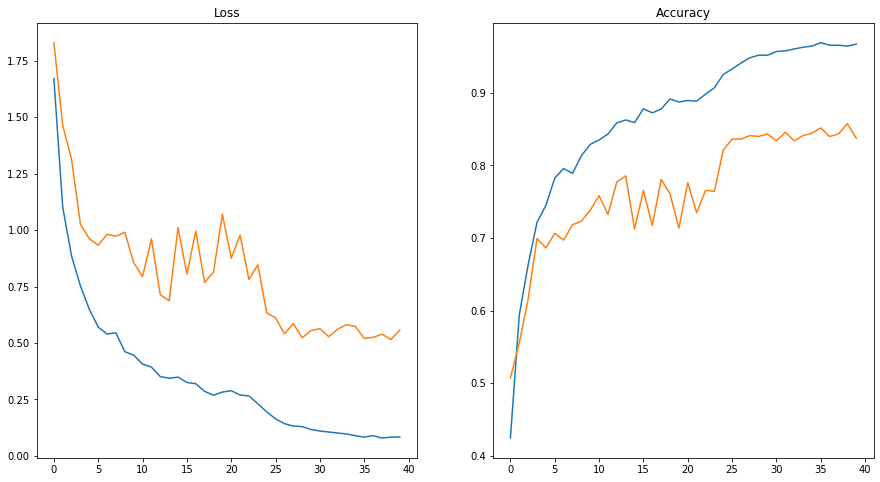

In [20]:
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
train_acc = trained_model.history['accuracy']
val_acc = trained_model.history['val_accuracy']
epochs = range(num_epochs)

plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.plot(epochs,loss,label="train_loss")
plt.plot(epochs,val_loss,label="val_loss")
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(epochs,train_acc,label="train_acc")
plt.plot(epochs,val_acc,label="val_acc")
plt.title("Accuracy")

plt.show()